### Instructions

We will be trying to predict if a customer will be renting a film this month based on their previous activity and other details. We will first construct a table with:

    Customer ID
    City
    Most rented film category
    Total films rented
    Total money spent
    How many films rented last month


In [102]:
import pymysql
import sqlalchemy
import passlib
from sqlalchemy import create_engine
import pandas as pd
import getpass # To get the password without showing the input
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from scipy import stats
from scipy.stats import kurtosis
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [103]:
## reading the data from the database
password = getpass.getpass()

········


In [104]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [105]:
# test the connection
data = pd.read_sql_query('SELECT * FROM sakila.film', engine)
data.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42


In [106]:
# 
#query = 'select r.customer_id, c.first_name, c.last_name, a.address, ci.city from customer as c \
#join rental as r ON r.customer_id = c.customer_id \
#join address as a ON a.address_id = c.address_id \
#join city as ci ON ci.city_id = a.city_id \
#group by r.customer_id \
#order by c.customer_id;'
query = 'select r.customer_id, c.first_name, c.last_name, a.address, ci.city, count(r.rental_id) as "movies_rented", sum(p.amount) as "money_spent" from customer as c \
join rental as r ON r.customer_id = c.customer_id \
join address as a ON a.address_id = c.address_id \
join city as ci ON ci.city_id = a.city_id \
join payment as p on p.rental_id=r.rental_id \
group by r.customer_id \
order by c.customer_id;'

customer_data = pd.read_sql_query(query, engine)
customer_data.head()

,customer_id,first_name,last_name,address,city,movies_rented,money_spent
0,1,MARY,SMITH,1913 Hanoi Way,Sasebo,32,118.68
1,2,PATRICIA,JOHNSON,1121 Loja Avenue,San Bernardino,27,128.73
2,3,LINDA,WILLIAMS,692 Joliet Street,Athenai,26,135.74
3,4,BARBARA,JONES,1566 Inegl Manor,Myingyan,22,81.78
4,5,ELIZABETH,BROWN,53 Idfu Parkway,Nantou,38,144.62


In [107]:
query = 'select c_d.customer_id, c_d.first_name, c_d.last_name,c_d.address,c_d.city, c_d.rentals, c_d. amount_spent,c_c.category_name, p_m.num_rental_train AS movies_previous, c_m.num_rental_test as movies_current from customer_data as c_d \
join cust_cat as c_c on c_c.customer_num = c_d.customer_id \
join previous_m as p_m on p_m.customer_id = c_d.customer_id \
join current_m as c_m on c_m.customer_id = c_d.customer_id' 

customer_data = pd.read_sql_query(query, engine)
customer_data.head()

,customer_id,first_name,last_name,address,city,rentals,amount_spent,category_name,movies_previous,movies_current
0,1,MARY,SMITH,1913 Hanoi Way,Sasebo,32,118.68,Classics,2,7
1,2,PATRICIA,JOHNSON,1121 Loja Avenue,San Bernardino,27,128.73,Sports,1,1
2,3,LINDA,WILLIAMS,692 Joliet Street,Athenai,26,135.74,Action,2,4
3,5,ELIZABETH,BROWN,53 Idfu Parkway,Nantou,38,144.62,Classics,1,5
4,6,JENNIFER,DAVIS,1795 Santiago de Compostela Way,Laredo,28,93.72,Drama,3,4


In [108]:
display(customer_data.describe())
display(customer_data.columns)
customer_data.dtypes

,customer_id,rentals,amount_spent,movies_previous,movies_current
count,476.000000,476.000000,476.000000,476.000000,476.000000
mean,299.497899,27.262605,114.836618,2.060924,3.848739
std,172.939618,5.126233,25.258705,1.130657,1.843971
min,1.000000,12.000000,50.850000,1.000000,1.000000
25%,147.750000,24.000000,97.485000,1.000000,2.000000
50%,300.500000,27.000000,112.735000,2.000000,4.000000
75%,450.250000,31.000000,130.705000,3.000000,5.000000
max,597.000000,46.000000,221.550000,8.000000,10.000000


Index(['customer_id', 'first_name', 'last_name', 'address', 'city', 'rentals',
       'amount_spent', 'category_name', 'movies_previous', 'movies_current'],
      dtype='object')

customer_id          int64
first_name          object
last_name           object
address             object
city                object
rentals              int64
amount_spent       float64
category_name       object
movies_previous      int64
movies_current       int64
dtype: object

#### Customer  id is not really numerical, as it describes the person and was generated at random, it is also not really categorical, as every entry will be different (not repeating)
#### Moreover,  I don't think that customer_id, the name, or the address are going to be relevant for our prediction.
#### More interesting is the past behavior, which is based on:
- rentals
- amount_spent
- movies previous month

movies_current month will be used for checking the results as the dependent variable.

In [109]:
# Let's drop the columns we don't need for now: first and last name, address
#let's make a copy of the dataframe before we start changing it:
cust_data = customer_data.copy()


Sci-Fi         57
Sports         48
Animation      46
Action         44
Foreign        35
Documentary    33
Family         31
Horror         26
Games          26
New            24
Drama          21
Music          20
Comedy         19
Classics       19
Children       14
Travel         13
Name: category_name, dtype: int64

Aurora        2
Monywa        1
Salzburg      1
Uluberia      1
Atlixco       1
             ..
Dzerzinsk     1
Avellaneda    1
Baicheng      1
Oyo           1
Mysore        1
Name: city, Length: 475, dtype: int64

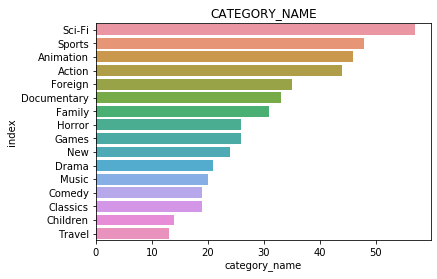

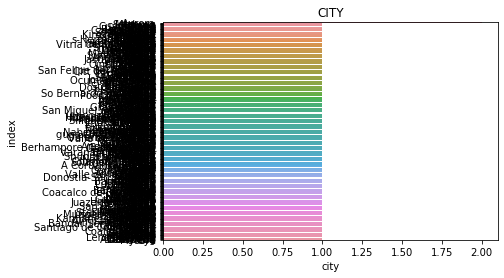

<Figure size 432x288 with 0 Axes>

In [110]:
    display(cust_data['category_name'].value_counts())
    my_data = cust_data['category_name'].value_counts().reset_index()
    ax = sns.barplot(x='category_name', y="index", data = my_data).set_title('category_name'.upper())
    plt.figure()
    print()   
    
    display(cust_data['city'].value_counts())
    my_data = cust_data['city'].value_counts().reset_index()
    ax = sns.barplot(x='city', y="index", data = my_data).set_title('city'.upper())
    plt.figure()
    print() 

In [111]:
# We also see that the cities are not repeating except for two customers who live in Aurora... we decide to drop city as well.

cust_data = cust_data.drop(['customer_id', 'first_name', 'last_name', 'address', 'city'], axis = 1)
cust_data.head()


,rentals,amount_spent,category_name,movies_previous,movies_current
0,32,118.68,Classics,2,7
1,27,128.73,Sports,1,1
2,26,135.74,Action,2,4
3,38,144.62,Classics,1,5
4,28,93.72,Drama,3,4


In [112]:
# So we see there are no empty fields in category_name, everything seems to be ok with our categorical column.
# lets convert it to numerical through OneHot encoding.
cat = pd.DataFrame(cust_data['category_name'])
display(cat)
cust_data = cust_data.drop(['category_name'],axis=1)

# we separate as well our dependent variable data from the rest
Y = pd.DataFrame(cust_data['movies_current'])
cust_data = cust_data.drop(['movies_current'],axis=1)

,category_name
0,Classics
1,Sports
2,Action
3,Classics
4,Drama
...,...
471,Horror
472,Sports
473,Documentary
474,Sports


In [113]:
# OneHot encodding - pd.getdummies
categorical = pd.get_dummies(cat, columns=['category_name'],drop_first=True)
categorical.head()
# with this, categorical is ready to be concatenated. Let's analyze the numerical values

,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


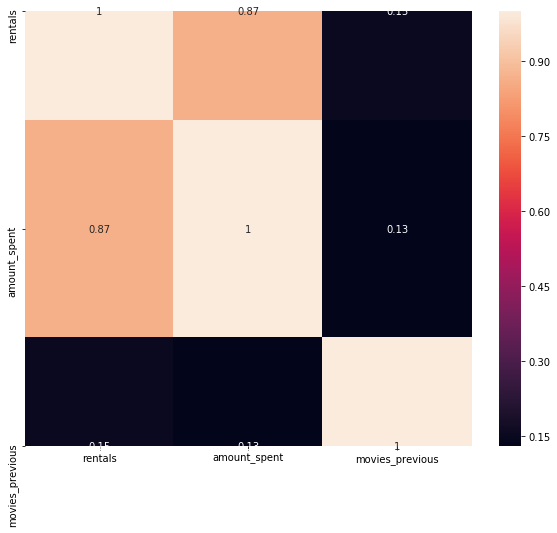

In [114]:
corr_matrix=cust_data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [115]:
cust_data.columns

Index(['rentals', 'amount_spent', 'movies_previous'], dtype='object')

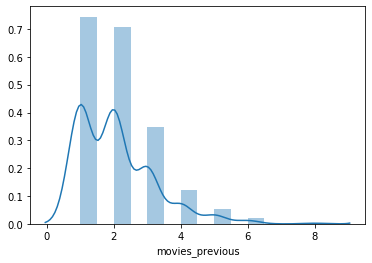

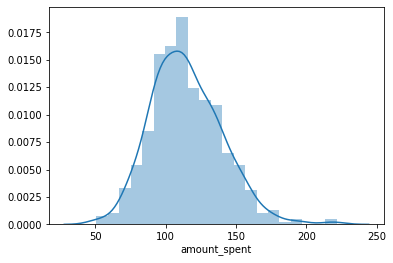

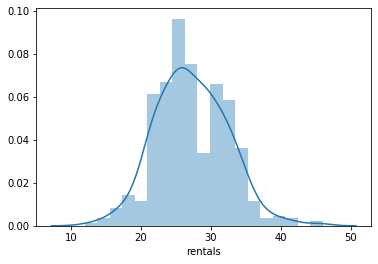

In [116]:
# we see that there is more or less no correlation between movies currentand movies previous 
# but there is correlation between movies current and amount_spent and number of rentals 

# let's check how does the distribution for each variable look like.


sns.distplot(cust_data['movies_previous'])
plt.show()
sns.distplot(cust_data['amount_spent'])
plt.show()
sns.distplot(cust_data['rentals'])
plt.show()

rentals            0.244194
amount_spent       0.558975
movies_previous    1.332515
dtype: float64

Q-Q plot for variable:  rentals


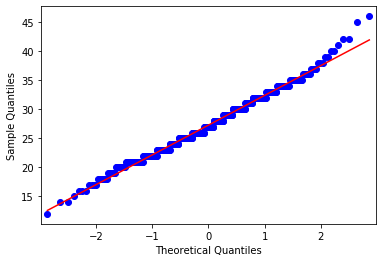

Q-Q plot for variable:  amount_spent


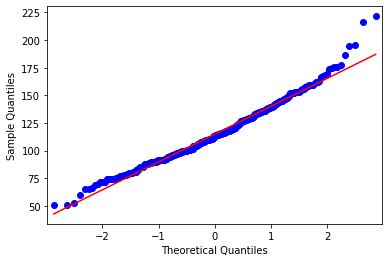

Q-Q plot for variable:  movies_previous


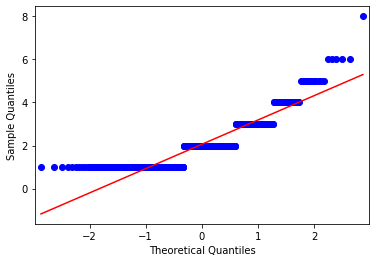

array([0.31377793, 0.87080824, 2.3143577 ])

In [117]:
# Let'S do some normality checks:

# Normality tests
# Checking for skewness and spikeness of numerical data
display(cust_data.apply(skew))
# Q-Q Plot
cols = list(cust_data.columns)
for col in cols:
    print("Q-Q plot for variable: ",col)
    qqplot(cust_data[col], line='s')
    pyplot.show()
    
#Kurtosis
kurtosis(cust_data)

Based on these results, we see that while amoun_spent and rentals close to normally distributed, 
We don't observe the same behavior for movies_previous
They all seem to be within the acceptable range though... let's see what the model 
would predict without applying any transformation

## We need to rescale, otherwise the results are not converging and we get errors.



In [118]:
# We will try the Standarizer
# scaling data
transformer = StandardScaler().fit(cust_data)
x_standarized = transformer.transform(cust_data)
x_standarized = pd.DataFrame(x_standarized)

In [119]:
X = np.concatenate((x_standarized, categorical), axis=1)

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [128]:
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, Y_train)
predictions = classification.predict(X_test)

display(predictions)

C:\Users\Borja\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([2, 1, 4, 2, 4, 4, 6, 4, 4, 3, 4, 4, 2, 4, 4, 3, 4, 4, 3, 3, 2, 2,
       2, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 2, 6, 4, 4, 4, 3, 4, 4, 3, 4, 4,
       4, 4, 6, 4, 4, 3, 4, 8, 1, 6, 4, 4, 5, 4, 4, 4, 4, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 6, 4, 2, 4, 4, 4, 2, 4, 4, 3, 3, 2, 5, 4, 5,
       4, 6, 3, 4, 2, 4, 4, 4, 4, 4, 2, 4, 3, 2, 4, 5, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4,
       5, 6, 4, 4, 5, 4, 2, 4, 4, 1, 2], dtype=int64)

In [129]:
MAE = mean_absolute_error(Y_test, predictions)
MSE = mean_squared_error(Y_test, predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(Y_test, predictions)

print("MAE of the linear model on test set: %5.3f"%(MAE))
print("MSE of the linear model on test set: %5.3f"%(MSE))
print("RMSE of the linear model on test set: %5.3f"%(RMSE))
print("R2 of the linear model on test set: %5.3f"%(R2))

MAE of the linear model on test set: 1.490
MSE of the linear model on test set: 3.336
RMSE of the linear model on test set: 1.826
R2 of the linear model on test set: 0.077
